In [39]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay

from task3_1 import preprocess_star_dataset, preprocess_gwp_dataset

## Star Dataset

In [2]:
def evaluate_classification_model(model, x_test, y_test, plot=True):
    y_pred = model.predict(x_test)
    print(f'Accuracy: {model.score(x_test, y_test)}')
    print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1-score: {f1_score(y_test, y_pred, average="weighted")}')
    if plot:
        ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['GALAXY', 'QSO', 'STAR'], cmap=plt.cm.Blues)

In [3]:
star_X, star_Y = preprocess_star_dataset('datasets/star_assessment.csv')

#### Train an SVM classifier using the holdout method

First let's split the dataset into training and test sets

In [4]:
star_x_train, star_x_test, star_y_train, star_y_test = train_test_split(star_X, star_Y, test_size=0.2, stratify=star_Y)

Then we can train a Support Vector Machine classifier using the training set and evaluate it using the test set

Accuracy: 0.9651346142615196
Precision: 0.9650226399762944
Recall: 0.9651346142615196
F1-score: 0.9645091514849647


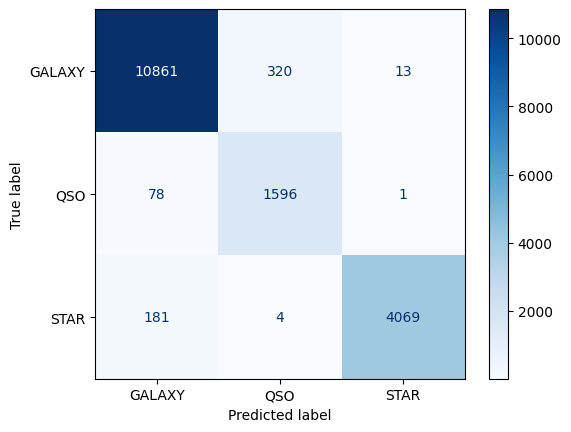

In [13]:
svc_holdout = SVC()
svc_holdout.fit(star_x_train, star_y_train)
evaluate_classification_model(svc_holdout, star_x_test, star_y_test)

#### Train an SVM classifier using cross-validation

Next, we can train an SVM classifier using cross-validation to get a better estimate of the model's performance, and calculate the mean accuracy and standard deviation of the model's performance across the folds

In [16]:
svc_cv = SVC()
svc_cv_scores = cross_val_score(svc_cv, star_X, star_Y, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {svc_cv_scores.mean()}')
print(f'Standard deviation: {svc_cv_scores.std()}')

Mean accuracy: 0.9644096152996191
Standard deviation: 0.0008522282547938581


#### Perform SVM classifier hyperparameter tuning

In [ ]:
param_grid = {
#     'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#     'degree': [2, 3],
#     'gamma': ['scale', 'auto', 0.1, 1, 10, 100]
}

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(star_X, star_Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [9]:
grid_search.best_params_

## GWP Dataset

In [36]:
def evaluate_regression_model(model, x_test, y_test, plot=True):
    y_pred = model.predict(x_test)
    print(f'R^2 Score: {r2_score(y_test, y_pred)}')
    print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
    print(f'Root Mean Squared Error: {mean_squared_error(y_test, y_pred, squared=False)}')
    if plot:
        max_val = max(np.max(y_test), np.max(y_pred))
        plt.scatter(y_test, y_pred)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.xlim([0, max_val])
        plt.ylim([0, max_val])
        plt.title('Actual vs Predicted Values')
        plt.plot([0, max_val], [0, max_val], 'g--')
        plt.show()

In [7]:
gwp_X, gwp_Y = preprocess_gwp_dataset('datasets/gwp_assessment.csv')

#### Train a Random Forest Regressor using the holdout method

First let's split the dataset into training and test sets

In [13]:
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = train_test_split(gwp_X, gwp_Y, test_size=0.2)

Then we can train a Random Forest Regressor using the training set and evaluate it using the test set

R^2 Score: 0.2922012194034407
Mean Absolute Error: 0.08960017732032323
Root Mean Squared Error: 0.14682628971458545


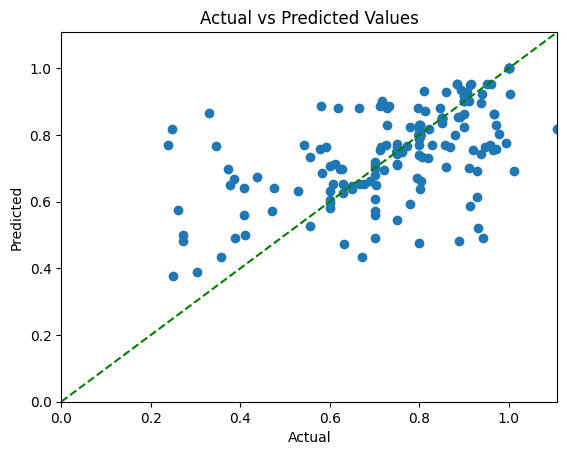

In [40]:
rf_holdout = RandomForestRegressor()
rf_holdout.fit(gwp_x_train, gwp_y_train)
evaluate_regression_model(rf_holdout, gwp_x_test, gwp_y_test)

#### Train a Random Forest Regressor using cross-validation

Next, we can train a Random Forest Regressor using cross-validation to get a better estimate of the model's performance, and calculate the mean R^2 score and standard deviation of the model's performance across the folds

In [41]:
rf_cv = RandomForestRegressor()
rf_cv_scores = cross_val_score(rf_cv, gwp_X, gwp_Y, scoring='r2', n_jobs=-1, cv=10)
print(f'Mean R^2 score: {rf_cv_scores.mean()}')
print(f'Standard deviation: {rf_cv_scores.std()}')

Mean R^2 score: 0.221383516730067
Standard deviation: 0.10515975628153912


#### Perform Random Forest Regression hyperparameter tuning

In [44]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor()
rf_grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

In [45]:
rf_grid_search.fit(gwp_X, gwp_Y)

print(f'Best Parameters')
for k, v in rf_grid_search.best_params_.items():
    print(f'{k}: {v}')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters
bootstrap: True
max_depth: 10
min_samples_leaf: 4
min_samples_split: 5
n_estimators: 200


R^2 Score: 0.30374894262695595
Mean Absolute Error: 0.08865233300989023
Root Mean Squared Error: 0.14562363018187013


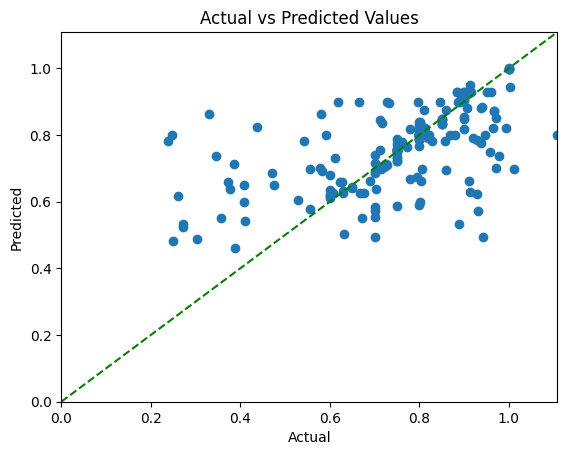

In [46]:
rf_tuned = RandomForestRegressor(n_estimators=rf_grid_search.best_params_['n_estimators'],
                                 max_depth=rf_grid_search.best_params_['max_depth'],
                                 min_samples_split=rf_grid_search.best_params_['min_samples_split'],
                                 min_samples_leaf=rf_grid_search.best_params_['min_samples_leaf'],
                                 bootstrap=rf_grid_search.best_params_['bootstrap'])
rf_tuned.fit(gwp_x_train, gwp_y_train)
evaluate_regression_model(rf_tuned, gwp_x_test, gwp_y_test)

## Markdown Question

*Is Linear Regression a good model to use for the star dataset? Justify your answer.*

Linear regression models assume a linear relationship between the features and the target variable, which isn't true in the case of many classification problems. In the star dataset, the target variable is categorical, namely having the classes `galaxy`, `qso` and `star`, meaning it is suited to be a classification task. Therefore, linear regression isn't a suitable model to use for this dataset, as there may not be a linear relationship between the features and the target. Additionally, using a linear regression model for the star dataset may result in predictions being made that don't fall into any of the three categories, making the predictions harder to interpret (and in certain cases, meaningless). Another reason why they shouldn't be used is that evaluation metrics commonly used for regression models, such as RMSE, are not suitable to be used for classification tasks, which use other metrics, including accuracy and F1-score. Finally, linear regression models are more sensitive to outliers than those suited to classification, which may result in the model being less accurate than a classification model.